## Babelscape WikiNeural Joined: Fine-Tune Multilingual NER

Dataset Source: https://huggingface.co/datasets/dmargutierrez/Babelscape-wikineural-joined

#### Install Necessary Libraries

In [1]:
%pip install transformers datasets evaluate seqeval tensorboard
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=4009262e158659eff48adee1426787e787d9cc2ef40e20ed77356e337b031b34
  St

#### HuggingFace Access

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Import Necessary Libraries

In [3]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import datasets
from datasets import load_dataset, DatasetDict
from datasets import Dataset, concatenate_datasets

import torch
from torch.nn.functional import cross_entropy

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import Trainer, TrainingArguments

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [4]:
print("Python :".rjust(18), sys.version[0:6])
print("NumPy :".rjust(18), np.__version__)
print("Pandas :".rjust(18), pd.__version__)
print("Torch :".rjust(18), torch.__version__)
print("Transformers :".rjust(18), transformers.__version__)
print("Datasets :".rjust(18), datasets.__version__)
print("Evaluate :".rjust(18), evaluate.__version__)
print("Sklearn :".rjust(18), sklearn.__version__)

          Python : 3.10.1
           NumPy : 1.23.5
          Pandas : 1.5.3
           Torch : 2.0.1+cu118
    Transformers : 4.31.0
        Datasets : 2.14.4
        Evaluate : 0.4.0
         Sklearn : 1.2.2


#### Ingest English Subset of Dataset

In [5]:
data = load_dataset("dmargutierrez/Babelscape-wikineural-joined")

print(f"Training Dataset Information: \n{data['train']}")
print(f"Testing Dataset Information: \n{data['test']}")
print(f"Evaluation Dataset Information: \n{data['validation']}")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/821600 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/102700 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/103206 [00:00<?, ? examples/s]

Training Dataset Information: 
Dataset({
    features: ['tokens', 'ner_tags', 'lang'],
    num_rows: 821600
})
Testing Dataset Information: 
Dataset({
    features: ['tokens', 'ner_tags', 'lang'],
    num_rows: 103206
})
Evaluation Dataset Information: 
Dataset({
    features: ['tokens', 'ner_tags', 'lang'],
    num_rows: 102700
})


#### Example

In [6]:
sample = data['train'][12]

sample

{'tokens': ['Demasiado',
  'longe',
  'dos',
  'seus',
  'cavalos',
  'para',
  'os',
  'recuperar',
  ',',
  'tiveram',
  'de',
  'esconder',
  'a',
  'maior',
  'parte',
  'dos',
  'seus',
  'bens',
  'e',
  'andar',
  'a',
  'pé',
  'o',
  'resto',
  'do',
  'caminho',
  'até',
  'ao',
  'rio',
  'Colúmbia',
  ',',
  'onde',
  'fizeram',
  'outras',
  'canoas',
  'e',
  'viajaram',
  'até',
  'ao',
  'recém-fundado',
  'Fort',
  'Astoria',
  '.'],
 'ner_tags': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  6,
  0],
 'lang': 'pt'}

#### Display Feature Information About Each Feature

In [7]:
for k, v in data["train"].features.items():
    print(f"{k}: \n{v}\n")

tokens: 
Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)

ner_tags: 
Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)

lang: 
Value(dtype='string', id=None)



#### Define Tag Values & Conversions Between String & Integer Values

In [8]:
id2label = {
    0: "O",
    1: "B-PER",
    2: "I-PER",
    3: "B-ORG",
    4: "I-ORG",
    5: "B-LOC",
    6: "I-LOC",
    7: "B-MISC",
    8: "I-MISC"
}

label2id = {
    "B-LOC": 5,
    "B-MISC": 7,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-MISC": 8,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
}

tag_values = list(label2id.keys())
NUM_OF_LABELS = len(tag_values)

print(f"List of tag values: \n{tag_values}")
print(f"Number of NER Tags: \n{NUM_OF_LABELS}")
print(f"id2label: \n{id2label}")
print(f"label2id: \n{label2id}")

List of tag values: 
['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
Number of NER Tags: 
9
id2label: 
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}
label2id: 
{'B-LOC': 5, 'B-MISC': 7, 'B-ORG': 3, 'B-PER': 1, 'I-LOC': 6, 'I-MISC': 8, 'I-ORG': 4, 'I-PER': 2, 'O': 0}


#### Basic Values/Constants

In [9]:
MODEL_CKPT = "bert-base-multilingual-cased"

MODEL_NAME = f"{MODEL_CKPT}-fine_tuned-ner-WikiNeural_Multilingual"
NUM_OF_EPOCHS = 1

BATCH_SIZE = 64
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
WEIGHT_DECAY = 0.01

LR = 2e-5
DEVICE = torch.device("cuda")

STEPS = 500

#### Function to Tokenize & Align Inputs

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize_and_align_labels(samples):
    tokenized_inputs = tokenizer(samples["tokens"],
                                      truncation=True,
                                      is_split_into_words=True)

    labels = []

    for idx, label in enumerate(samples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        prev_word_idx = None
        label_ids = []
        for word_idx in word_ids: # set special tokens to -100
            if word_idx is None or word_idx == prev_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            prev_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

#### Apply Above Function to Tokenize Dataset

In [11]:
encoded_ds = data.map(tokenize_and_align_labels,
                       batched=True,
                       remove_columns=
                        [
                            'ner_tags',
                            'tokens',
                            'lang'
                        ]
                    )

Map:   0%|          | 0/821600 [00:00<?, ? examples/s]

Map:   0%|          | 0/102700 [00:00<?, ? examples/s]

Map:   0%|          | 0/103206 [00:00<?, ? examples/s]

#### Define Data Collator

In [12]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

#### Load Custom Model

In [13]:
model = (AutoModelForTokenClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id
    ).to(DEVICE))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Create Compute Metrics Function

In [14]:
label_list = tag_values

seqeval = evaluate.load("seqeval")

labels = [label_list[i] for i in sample[f'ner_tags']]

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions,
                            axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions,
                              references=true_labels)

    return results

#### Define TrainingArguments

In [15]:
args = TrainingArguments(
    MODEL_NAME,
    log_level="error",
    logging_first_step=True,
    learning_rate=LR,
    num_train_epochs=NUM_OF_EPOCHS,
    auto_find_batch_size=True,
    evaluation_strategy=STRATEGY,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    logging_steps=STEPS,
    weight_decay=WEIGHT_DECAY,
    save_strategy=STRATEGY,
    group_by_length=True,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [16]:
trainer = Trainer(model,
                  args=args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer,
                  train_dataset=encoded_ds["train"],
                  eval_dataset=encoded_ds["test"]
                  )

Cloning https://huggingface.co/DunnBC22/bert-base-multilingual-cased-fine_tuned-ner-WikiNeural_Multilingual into local empty directory.


#### Train Model

In [17]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Loc,Misc,Org,Per,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.015000,0.016823,"{'precision': 0.9983410191680872, 'recall': 0.99820099576644, 'f1': 0.9982710025571356, 'number': 1932180}","{'precision': 0.9809396911027518, 'recall': 0.9833044214778437, 'f1': 0.9821206328547606, 'number': 122787}","{'precision': 0.9868919798954698, 'recall': 0.9881129520338388, 'f1': 0.9875020885547201, 'number': 59813}","{'precision': 0.9386096837531854, 'recall': 0.9516901050491359, 'f1': 0.9451046377116415, 'number': 47216}",0.995711,0.996060,0.995886,0.994704


#### Push Model To Hub

In [18]:
kwargs = {
    "tasks": "token-classification",
    "tags": ['token-classification'],
}

if args.push_to_hub:
    trainer.push_to_hub('All DUNN!!!', **kwargs)
else:
    trainer.create_model_card(**kwargs)

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/676M [00:00<?, ?B/s]

Upload file runs/Aug14_15-43-45_1fa64856cc35/events.out.tfevents.1692027916.1fa64856cc35.856.0:   0%|         …

To https://huggingface.co/DunnBC22/bert-base-multilingual-cased-fine_tuned-ner-WikiNeural_Multilingual
   691d4be..0e5f4ef  main -> main

   691d4be..0e5f4ef  main -> main

To https://huggingface.co/DunnBC22/bert-base-multilingual-cased-fine_tuned-ner-WikiNeural_Multilingual
   0e5f4ef..f2864c2  main -> main

   0e5f4ef..f2864c2  main -> main



#### Save & Log Model

In [19]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

To https://huggingface.co/DunnBC22/bert-base-multilingual-cased-fine_tuned-ner-WikiNeural_Multilingual
   f2864c2..c3c7ca0  main -> main

   f2864c2..c3c7ca0  main -> main



***** train metrics *****
  epoch                    =        1.0
  total_flos               = 12872968GF
  train_loss               =     0.0249
  train_runtime            = 3:36:13.27
  train_samples_per_second =      63.33
  train_steps_per_second   =      7.916


### Error Analysis

#### Define Method to Apply to Validation Dataset (& Then Apply it)

In [26]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)
    labels = batch["labels"].to(DEVICE)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()

    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 9), labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

#### Apply Above Function to Entire Evaluation Dataset

In [27]:
eval_set = encoded_ds['validation']

eval_set = eval_set.map(forward_pass_with_label,
                        batched=True,
                        batch_size=32)

eval_df = eval_set.to_pandas()

Map:   0%|          | 0/102700 [00:00<?, ? examples/s]

#### Clean Up Padding Tokens

In [28]:
id2label[-100] = "IGN"
eval_df["input_tokens"] = eval_df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x))
eval_df["predicted_label"] = eval_df["predicted_label"].apply(
    lambda x: [id2label[i] for i in x])
eval_df["labels"] = eval_df["labels"].apply(
    lambda x: [id2label[i] for i in x])
eval_df['loss'] = eval_df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
eval_df['predicted_label'] = eval_df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
eval_df.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[101, 15595, 13322, 10317, 11793, 18166, 21162...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, O, O, IGN, IGN, O, O, O, O,...","[0.0, 6.079655e-06, 0.0, 0.0, 5.245195e-06, 7....","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[[CLS], Ab, ##ala, ##do, pela, eli, ##mina, ##..."


#### Unwrap Each Token Within Sample Separately

In [29]:
eval_df_tokens = eval_df.apply(pd.Series.explode)
eval_df_tokens = eval_df_tokens.query("labels != 'IGN'")
eval_df_tokens["loss"] = eval_df_tokens["loss"].astype(float).round(2)
eval_df_tokens.head(7)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,15595,0,1,O,0.0,O,Ab
0,11793,0,1,O,0.0,O,pela
0,18166,0,1,O,0.0,O,eli
0,117,0,1,O,0.0,O,","
0,183,0,1,O,0.0,O,o
0,10635,0,1,O,0.0,O,time
0,11420,0,1,O,0.0,O,não


#### See Which Tokens Have Accumulated Most Loss in Evaluation Dataset

In [30]:
(
    eval_df_tokens.groupby("input_tokens")[["loss"]]
    .agg(
        [
            "count",
            "mean",
            "sum"
        ]
        )
    .droplevel(level=0, axis=1) # Get rid of multi-level columns
    .sort_values(by="sum",
                 ascending=False)
    .reset_index()
    .round(3)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,de,»,«,di,G,К,М,S,Ass,C
count,53712,2449,2469,11129,2552,1351,989,1322,185,1167
mean,0.015,0.193,0.139,0.025,0.092,0.17,0.229,0.161,1.055,0.165
sum,823.44,472.53,343.37,275.77,235.48,229.28,226.8,212.37,195.16,192.92


#### See Which Label IDs Have Most Loss in Evaluation Dataset

In [31]:
(
    eval_df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # Get rid of multi-level columns
    .sort_values(by="mean",
                 ascending=False)
    .reset_index()
    .round(3)
    .fillna(0)
    .T
)

,0,1,2,3,4,5,6,7,8
labels,B-MISC,I-MISC,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,22690,29173,21663,24923,21930,77928,47547,44210,1920443
mean,0.256,0.178,0.149,0.119,0.084,0.071,0.063,0.02,0.005
sum,5799.19,5196.44,3233.22,2977.46,1838.05,5507.03,2974.66,880.47,9897.37


#### Create Function to Display Confusion Matrix

In [32]:
def plot_confusion_matrix(y_preds, y_true,
                          labels):
    cm = confusion_matrix(y_true, y_preds,
                          normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp.plot(cmap="Blues",
              values_format=".2f",
              ax=ax,
              colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

#### Display Confusion Matrix

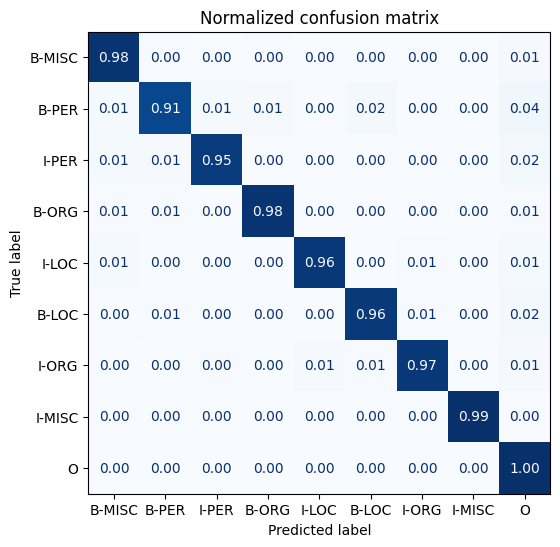

In [33]:
eval_token_list = list(set(eval_df_tokens['labels']))

plot_confusion_matrix(eval_df_tokens["labels"],
                      eval_df_tokens["predicted_label"],
                      eval_token_list)

### Notes & Other Takeaways From This Project

****
- While this model had some issues with detecting the beginning of persons (PER), this is minor; it is the only area of potential weakness of this model.

****

### Citations

- Dataset

    > @inproceedings{tedeschi-etal-2021-wikineural-combined, title = "{W}iki{NE}u{R}al: {C}ombined Neural and Knowledge-based Silver Data Creation for Multilingual {NER}", author = "Tedeschi, Simone and Maiorca, Valentino and Campolungo, Niccol{\`o} and Cecconi, Francesco and Navigli, Roberto", booktitle = "Findings of the Association for Computational Linguistics: EMNLP 2021", month = nov, year = "2021", address = "Punta Cana, Dominican Republic", publisher = "Association for Computational Linguistics", url = "https://aclanthology.org/2021.findings-emnlp.215", pages = "2521--2533", abstract = "Multilingual Named Entity Recognition (NER) is a key intermediate task which is needed in many areas of NLP. In this paper, we address the well-known issue of data scarcity in NER, especially relevant when moving to a multilingual scenario, and go beyond current approaches to the creation of multilingual silver data for the task. We exploit the texts of Wikipedia and introduce a new methodology based on the effective combination of knowledge-based approaches and neural models, together with a novel domain adaptation technique, to produce high-quality training corpora for NER. We evaluate our datasets extensively on standard benchmarks for NER, yielding substantial improvements up to 6 span-based F1-score points over previous state-of-the-art systems for data creation.",}

- Model Checkpoint

    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Metric (SeqEval)

    > @inproceedings{ramshaw-marcus-1995-text, title = "Text Chunking using Transformation-Based Learning", author = "Ramshaw, Lance and Marcus, Mitch", booktitle = "Third Workshop on Very Large Corpora", year = "1995", url = "https://www.aclweb.org/anthology/W95-0107",}
    
    > @misc{seqeval, title={{seqeval}: A Python framework for sequence labeling evaluation}, url={https://github.com/chakki-works/seqeval}, note={Software available from https://github.com/chakki-works/seqeval}, author={Hiroki Nakayama}, year={2018},}